# <center> SESA Model </center>
## <center> Geographic Variables Analysis </center>

In the present notebook, we're going to analyze the geographic information of trips using correspondence analysis.
<!-- En este notebook analizamos la ubicación geográfica de los viajes y los viajes interarroquiales, intercantonales e interprovinciales utilizando análisis de correspondencias.
-->

In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(spark.sparkContext, '1fd9d05d-fd02-4f2c-831b-71b3b7c78dc8', 'p-d1f0f40843c6a41468a0f07f797f8b4006e0a3df')
pc = project.project_context


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191106145952-0000
KERNEL_ID = a419d240-33d4-4016-bb59-70741b9a32e3


In [2]:
# Spark required imports
from pyspark.sql import SparkSession
from pyspark.sql import types
from pyspark.sql import Window
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import when

import pandas as pd

# Access to IBM Cloud Object Storage
import ibmos2spark

# Python Utilities
from datetime import datetime

## Service Credentials

In [3]:
# @hidden_cell

#Local repository credentials for intermediate storage
local_credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-cf3a42e6-b837-4052-95bd-2c70d622ca79',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': '63uTPR7Y3-r6cKbWhkZLEfMOvwH81aD-aIa_fM0mjupN'
}

local_config_name = 'os_dad6a34ab1754ee2b506e620972cf9fe_configs'
local_cos = ibmos2spark.CloudObjectStorage(sc, local_credentials, local_config_name, 'bluemix_cos')
local_bucket = 'modeloderiesgosesa-donotdelete-pr-cymgsbtnuhfnlj'

Cargar el conjunto de datos de viajes para analizar las variables geográficas.

In [4]:
name = "TripFacts5_Geo"
Trips_geo = spark.read.parquet(local_cos.url(name, local_bucket))
print('Done')
#print('Number of rows: ', "{:,}".format(Trips_geo.count()))
Trips_geo.printSchema()

Done
root
 |-- DeviceId: long (nullable = true)
 |-- TripID: long (nullable = true)
 |-- Dist_km: double (nullable = true)
 |-- Duration_h: double (nullable = true)
 |-- DistanciaST: double (nullable = true)
 |-- DuracionST_h: double (nullable = true)
 |-- Dur_50_h: double (nullable = true)
 |-- Dur_70_h: double (nullable = true)
 |-- Dur_80_h: double (nullable = true)
 |-- Dur_90_h: double (nullable = true)
 |-- Dur_100_h: double (nullable = true)
 |-- Dist_50: double (nullable = true)
 |-- Dist_70: double (nullable = true)
 |-- Dist_80: double (nullable = true)
 |-- Dist_90: double (nullable = true)
 |-- Dist_100: double (nullable = true)
 |-- Latitude_ON: double (nullable = true)
 |-- Longitude_ON: double (nullable = true)
 |-- EC_Time_ON: timestamp (nullable = true)
 |-- Latitude_OFF: double (nullable = true)
 |-- Longitude_OFF: double (nullable = true)
 |-- EC_Time_OFF: timestamp (nullable = true)
 |-- DayTime: string (nullable = true)
 |-- DayType: string (nullable = true)
 |-- D

In [5]:
Trips_geo.select("DeviceId").agg(F.countDistinct("DeviceId")).show()

+------------------------+
|count(DISTINCT DeviceId)|
+------------------------+
|                   11225|
+------------------------+



In [6]:
#print('Number of rows: ', "{:,}".format(Trips_geo.count()))

Now, let’s filter the devices which don’t have enough telemetry to be analyzed. We will only select devices which have at least 90 days of installation until September 30, 2019 and at least 90 days of telemetry information.

First, read de data set with the installation dates.

<!--
Leer el conjunto que tiene la información de fechas de instalación de los dispositivos. Luego vamos a agregar la fecha de instalación para eleminar los dispositivos que tienen menos 90 días de instalación del dispositivo.
-->

In [7]:
name = 'data_asset/Dispositivos_Prod_Ene-Sep-2019_install_date_7ffcc8d3'
spark_dev_inst = spark.read.parquet(local_cos.url(name, local_bucket))
spark_dev_inst.printSchema()

root
 |-- DeviceId: integer (nullable = true)
 |-- installeddate: string (nullable = true)



In [8]:
dev_df = Trips_geo.select('DeviceId', 'Date').groupBy('DeviceId').agg(F.min('Date').alias('min_date'),F.max('Date').alias('max_date'))
dev_df.show(10)

+--------+----------+----------+
|DeviceId|  min_date|  max_date|
+--------+----------+----------+
|   35484|2019-03-14|2019-09-29|
|   27919|2019-01-01|2019-09-30|
|   30562|2019-01-01|2019-09-30|
|   28078|2018-12-31|2019-09-30|
|   31762|2019-01-02|2019-09-29|
|   38108|2019-06-01|2019-09-29|
|   38510|2019-06-12|2019-09-29|
|   40557|2019-07-20|2019-09-30|
|   42852|2019-09-03|2019-09-30|
|   39256|2019-06-25|2019-09-30|
+--------+----------+----------+
only showing top 10 rows



 Filter the devices whose difference between the minimum and maximum date is less than 89 days.
 
<!--
Eliminar los dispositivos cuya diferencia entre la fecha máxima y mínima sea menor que 90 días.
-->

In [9]:
dev_df = dev_df.withColumn('days_passed', F.datediff(F.lit(F.col('max_date')), F.lit(F.col('min_date'))))
dev_df = dev_df.where('days_passed>89')
#dev_df.orderBy('days_passed').show(10)

In [10]:
dev_df = dev_df.join(spark_dev_inst.select("DeviceId", 'installeddate'), ["DeviceId"])
dev_df = dev_df.dropDuplicates()
dev_df.printSchema()

root
 |-- DeviceId: long (nullable = true)
 |-- min_date: date (nullable = true)
 |-- max_date: date (nullable = true)
 |-- days_passed: integer (nullable = true)
 |-- installeddate: string (nullable = true)



In [11]:
dev_df = dev_df.withColumn("circ_time", F.datediff(F.to_date(F.lit("2019-09-30")), F.lit(F.col('installeddate'))))

In [12]:
dev_df = dev_df.withColumn('dias_circ', F.when(F.col('circ_time')<F.col('days_passed'),F.col('days_passed')).otherwise(F.col('circ_time')))

Select the devices with at least 90 days of installation.
<!--Seleccionar dispositivos con al menos 90 días de instalación del dispositivo.-->

In [13]:
date_df = dev_df.where('dias_circ>89').toPandas()
date_df[['dias_circ']].describe()

,dias_circ
count,7251.000000
mean,239.427803
std,101.314447
min,90.000000
25%,152.000000
50%,231.000000
75%,311.000000
max,742.000000


In [14]:
l_dev = list(date_df['DeviceId'] )
print(len(l_dev))
l_dev[0:10]

7251


[28078, 37884, 34340, 39527, 33209, 34821, 32667, 30562, 32912, 33862]

In [15]:
#print('Number of rows: ', "{:,}".format(Trips_f.count()))

In [16]:
Trips_f = Trips_geo.where(Trips_geo.DeviceId.isin(l_dev))
Trips_f = Trips_f.dropDuplicates()
Trips_f = Trips_f.dropna() #Eliminar las celdas con datos nulos para hacer el análisis de correspondencias
#Trips_f.select("DeviceId", 'TripID').groupBy('DeviceId').agg(F.countDistinct('TripID').alias("n_trips")).describe(["n_trips"]).show()

In [17]:
print('Number of rows: ', "{:,}".format(Trips_f.count()))#2,668,022

Number of rows:  2,668,022


## Interparish, intercantonal and interprovince trips 


The Republic of Ecuador is divided into 24 provinces. Each province is divided into cantons and cantons are divided into parish. We have created the categories A, B, C and D for each trip:

*	Trip type A: when the ignition on is registered in a certain parish and the ignition off is registered in the same parish.
*	Trip type B: when the ignition on is registered in a certain parish but the ignition off is registered in another parish.
*	Trip type C: when the ignition on is registered in a certain canton but the ignition off is registered in another canton.
*	Trip type D: when the ignition on is registered in a certain province but the ignition off is registered in another province.



In [18]:
Trips_f = Trips_f.withColumn('Tipo_Viaje', F.when((F.col('ViajeInterparroquial')*F.col('ViajeIntercantonal')*F.col('ViajeInterprovincial'))>0,'D').otherwise(F.when((F.col('ViajeInterparroquial')*F.col('ViajeIntercantonal'))>0,'C').otherwise(F.when(F.col('ViajeInterparroquial')>0,'B').otherwise('A'))))

In [19]:
Trips_f.select('DeviceId', 'TripID', 'ON_N3', 'ON_N2', 'ON_N1', 'OFF_N3', 'OFF_N2', 'OFF_N1', 'ViajeInterparroquial', 'ViajeIntercantonal', 'ViajeInterprovincial', 'Tipo_Viaje').show(10)

+--------+--------+------------+--------+----------+------+------+----------+--------------------+------------------+--------------------+----------+
|DeviceId|  TripID|       ON_N3|   ON_N2|     ON_N1|OFF_N3|OFF_N2|    OFF_N1|ViajeInterparroquial|ViajeIntercantonal|ViajeInterprovincial|Tipo_Viaje|
+--------+--------+------------+--------+----------+------+------+----------+--------------------+------------------+--------------------+----------+
|   28745|18577217|    Riobamba|Riobamba|Chimborazo|Penipe|Penipe|Chimborazo|                   1|                 1|                   0|         C|
|   33831|17897716|  El Quinche|   Quito| Pichincha| Quito| Quito| Pichincha|                   1|                 0|                   0|         B|
|   31726|25902525|Guayllabamba|   Quito| Pichincha| Quito| Quito| Pichincha|                   1|                 0|                   0|         B|
|   34434|28979668|Guayllabamba|   Quito| Pichincha| Quito| Quito| Pichincha|                   1|  

In [20]:
Trips_f.groupBy('Tipo_Viaje').count().show()

+----------+-------+
|Tipo_Viaje|  count|
+----------+-------+
|         B| 283629|
|         D|  24267|
|         C| 242977|
|         A|2117149|
+----------+-------+



## Province of ignition off vs Trip type

Calculate the frequency table in spark using the command `.crosstab()`

In [21]:
freq_tab_Prov = Trips_f.crosstab('OFF_N1','Tipo_Viaje')


print('Frequency table for Off locations')
print('Number of rows: ', "{:,}".format(freq_tab_Prov.count()))
print('Number of columns: ', len(freq_tab_Prov.columns))


Frequency table for Off locations
Number of rows:  24
Number of columns:  5


In [22]:
#freq_tab_Prov.columns
freq_tab_Prov.show()
#freq_tab_Prov = freq_tab_Prov.drop([])

+--------------------+------+------+------+----+
|   OFF_N1_Tipo_Viaje|     A|     B|     C|   D|
+--------------------+------+------+------+----+
|             Bolivar|  5402|   243|   561| 433|
|         Santa Elena| 16942|  2408|  8211| 262|
|            Los Rios| 19186|   697|  1901|1442|
|          Chimborazo| 26182|  2313|  3127|1078|
|          Tungurahua| 66416| 19432|  6584|2072|
|                Napo|  3083|  1027|   829| 395|
|            Orellana|  2462|   757|   253| 143|
|           Pichincha|867625|208262| 63887|2993|
|             Pastaza|  5770|   963|  1064| 236|
|                Loja| 76247|  2838|  2047| 312|
|               Azuay| 97911| 14929|  3254|2433|
|           Sucumbios|  6327|   752|   544| 145|
|     Morona Santiago|  3297|   698|   428|  80|
|Santo Domingo de ...| 47953|  1392|     0|1268|
|          Esmeraldas| 15811|  3362|  2330| 527|
|              Guayas|648677|  7419|118701|2075|
|              Carchi|  5697|   743|   620| 329|
|            Imbabur

In [23]:
## Utilizamos la librería prince para hacer análisis de correspondencias 
!pip install prince

    100% |################################| 10.4MB 1.8MB/s eta 0:00:01
    100% |################################| 6.7MB 2.2MB/s eta 0:00:01
    100% |################################| 20.0MB 1.1MB/s eta 0:00:01
    100% |################################| 13.1MB 1.5MB/s eta 0:00:01
    100% |################################| 25.2MB 965kB/s eta 0:00:01
    100% |################################| 512kB 5.1MB/s eta 0:00:01
    100% |################################| 235kB 4.4MB/s eta 0:00:01
    100% |################################| 296kB 5.8MB/s eta 0:00:01
    100% |################################| 92kB 5.1MB/s eta 0:00:01
    100% |################################| 71kB 3.6MB/s eta 0:00:01
    100% |################################| 583kB 4.8MB/s eta 0:00:01
tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.


In [24]:
import prince #python library for correspondance analysis

In [25]:
X = freq_tab_Prov.toPandas()
X = X.set_index('OFF_N1_Tipo_Viaje', drop=True)
X.columns.rename('Tipo Viaje', inplace=True)
X.index.rename('Prov OFF', inplace=True)
#X.drop(['A', 
#        'Zamora Chinchipe', 'Loja',
#        'Carchi', 'Imbabura', 'CaÃ±ar', 'Azuay'
#      ], axis=1, inplace=True)
X.drop(['Zona No Delimitada', 
#        'Loja', 'Zamora Chinchipe',
        #'Carchi', 'Imbabura', 'CaÃ±ar', 'Azuay'
       ], axis=0, inplace=True)
X.head()

Tipo Viaje,A,B,C,D
Prov OFF,,,,
Bolivar,5402,243,561,433
Santa Elena,16942,2408,8211,262
Los Rios,19186,697,1901,1442
Chimborazo,26182,2313,3127,1078
Tungurahua,66416,19432,6584,2072


In [26]:
X.sort_values(by='C', ascending=False)

Tipo Viaje,A,B,C,D
Prov OFF,,,,
Guayas,648677,7419,118701,2075
Pichincha,867625,208262,63887,2993
Manabi,81196,4226,12522,902
Imbabura,68021,4572,8828,1668
Santa Elena,16942,2408,8211,262
Tungurahua,66416,19432,6584,2072
El Oro,19625,964,3619,218
Azuay,97911,14929,3254,2433
Chimborazo,26182,2313,3127,1078


In [27]:
ca = prince.CA(n_components=3,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
ca = ca.fit(X)

In [28]:
ca.explained_inertia_

[0.6324701885893432, 0.2615881318456836, 0.10594167956497327]

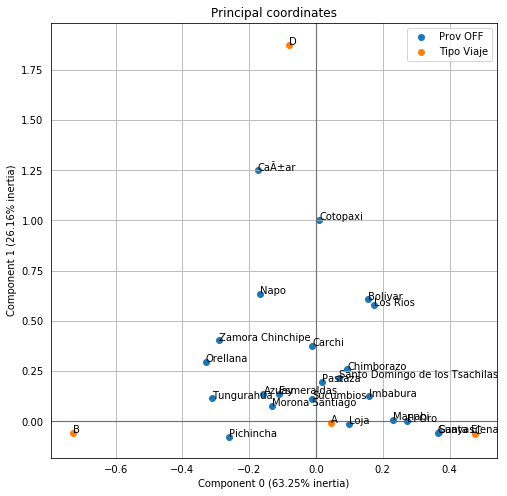

In [29]:
ax = ca.plot_coordinates(X=X,ax=None,figsize=(8, 8),x_component=0,y_component=1,show_row_labels=True,show_col_labels=True)

Let's remove the type A trips for a better visualization.

In [30]:
X = freq_tab_Prov.toPandas()
X = X.set_index('OFF_N1_Tipo_Viaje', drop=True)
X.columns.rename('Tipo Viaje', inplace=True)
X.index.rename('Prov OFF', inplace=True)
X.drop(['A', 
#        'Zamora Chinchipe', 'Loja',
#        'Carchi', 'Imbabura', 'CaÃ±ar', 'Azuay'
      ], axis=1, inplace=True)
X.drop(['Zona No Delimitada', 
#        'Loja', 'Zamora Chinchipe',
        #'Carchi', 'Imbabura', 'CaÃ±ar', 'Azuay'
       ], axis=0, inplace=True)
X.head()

Tipo Viaje,B,C,D
Prov OFF,,,
Bolivar,243,561,433
Santa Elena,2408,8211,262
Los Rios,697,1901,1442
Chimborazo,2313,3127,1078
Tungurahua,19432,6584,2072


Explained Inertia:
 [0.7193617346674264, 0.28063826533257347, 3.357606915419598e-32]


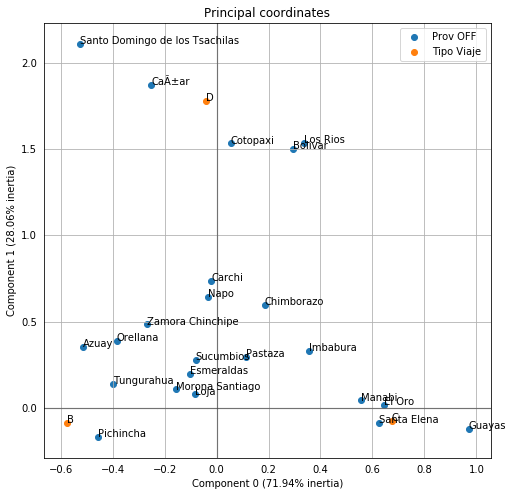

In [31]:
ca = prince.CA(n_components=3,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
ca = ca.fit(X)
print("Explained Inertia:\n", ca.explained_inertia_)
ax = ca.plot_coordinates(X=X,ax=None,figsize=(8, 8),x_component=0,y_component=1,show_row_labels=True,show_col_labels=True)

The graph above tells us:
*	Pichincha and Tungurahua are highly correlated with the trips type B (interparish).
*	Guayas, Santa Elena, Manabí and El Oro are highly correlated with the trips type C (intercantonal).
*	The type D trips (interprovince) seem to occur more in Cañar and Cotopaxi.


## Province of ignition on vs Trip type

In [32]:
freq_tab_Prov_on = Trips_f.crosstab('ON_N1','Tipo_Viaje')


print('Frequency table for Off locations')
print('Number of rows: ', "{:,}".format(freq_tab_Prov_on.count()))
print('Number of columns: ', len(freq_tab_Prov_on.columns))


Frequency table for Off locations
Number of rows:  24
Number of columns:  5


In [33]:
X = freq_tab_Prov_on.toPandas()
X = X.set_index('ON_N1_Tipo_Viaje', drop=True)
X.columns.rename('Tipo Viaje', inplace=True)
X.index.rename('Prov ON', inplace=True)
X.drop(['A', 
#        'Zamora Chinchipe', 'Loja',
        #'Carchi', 'Imbabura', 'CaÃ±ar', 'Azuay'
      ], axis=1, inplace=True)
X.drop(['Zona No Delimitada', 
#        'Loja', 'Zamora Chinchipe',
        #'Carchi', 'Imbabura', 'CaÃ±ar', 'Azuay'
       ], axis=0, inplace=True)
X.head()

Tipo Viaje,B,C,D
Prov ON,,,
Bolivar,243,561,365
Santa Elena,2408,8211,214
Los Rios,697,1901,1549
Chimborazo,2313,3127,960
Tungurahua,19432,6584,2116


In [34]:
X

Tipo Viaje,B,C,D
Prov ON,,,
Bolivar,243,561,365
Santa Elena,2408,8211,214
Los Rios,697,1901,1549
Chimborazo,2313,3127,960
Tungurahua,19432,6584,2116
Napo,1027,829,376
Orellana,757,253,144
Pichincha,208262,63887,2974
Pastaza,963,1064,247


In [35]:
ca = prince.CA(n_components=3,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
ca = ca.fit(X)
ca.explained_inertia_

[0.7214557751242523, 0.27854422487574765, 4.323828810640267e-34]

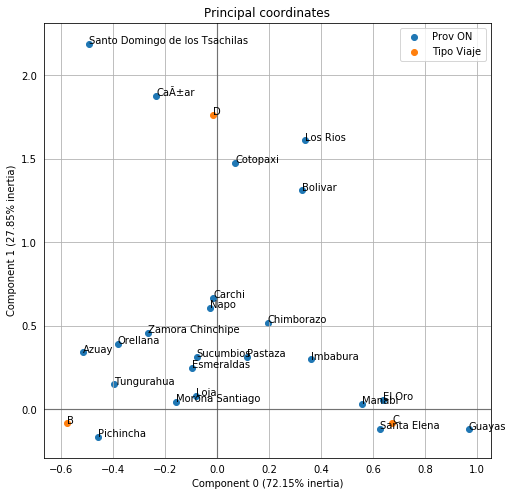

In [36]:
ax = ca.plot_coordinates(X=X,ax=None,figsize=(8, 8),x_component=0,y_component=1,show_row_labels=True,show_col_labels=True)

The behavior for the ignition on vs the trip type is like the behavior of ignition off.

## Device vs Trip type

In [37]:
#ft_Dev_TV = Trips_f.where(F.col('Tipo_Viaje')!='A').crosstab('DeviceId', 'Tipo_Viaje')
ft_Dev_TV = Trips_f.crosstab('DeviceId', 'Tipo_Viaje')
print('Frequency table for trip types for each Device')
print('Number of rows: ', "{:,}".format(ft_Dev_TV.count()))
print('Number of columns: ', len(ft_Dev_TV.columns))

Frequency table for trip types for each Device
Number of rows:  7,250
Number of columns:  5


In [38]:
ft_Dev_TV.show(5)

+-------------------+---+---+---+---+
|DeviceId_Tipo_Viaje|  A|  B|  C|  D|
+-------------------+---+---+---+---+
|              37159| 87|  7|  0|  1|
|              31843|297|  6| 84|  0|
|              39241| 26| 18|  0|  0|
|              29862|122| 14| 20|  0|
|              39049| 99|  0| 56|  0|
+-------------------+---+---+---+---+
only showing top 5 rows



In [39]:
X = ft_Dev_TV.toPandas()
X = X.set_index('DeviceId_Tipo_Viaje', drop=True)
X.columns.rename('Tipo Viaje', inplace=True)
X.index.rename('Device', inplace=True)
#X.drop(['A', 'D'], axis=1, inplace=True)
#X.drop(['Zona No Delimitada', 
#        'Loja', 'Zamora Chinchipe',
        #'Carchi', 'Imbabura', 'CaÃ±ar', 'Azuay'
#       ], axis=0, inplace=True)
X = X.dropna()
X = X.loc[~(X==0).all(axis=1)]
X.head()

Tipo Viaje,A,B,C,D
Device,,,,
37159,87,7,0,1
31843,297,6,84,0
39241,26,18,0,0
29862,122,14,20,0
39049,99,0,56,0


In [40]:
X.sort_values(by=['B','C','D']).head(10)

Tipo Viaje,A,B,C,D
Device,,,,
37494,85,0,0,0
37793,275,0,0,0
31207,327,0,0,0
37369,227,0,0,0
33453,168,0,0,0
34213,266,0,0,0
34501,19,0,0,0
38515,153,0,0,0
37087,83,0,0,0


In [41]:
ca = prince.CA(n_components=2,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
ca = ca.fit(X)
ca.explained_inertia_

[0.4617724977308656, 0.37988469386111484]

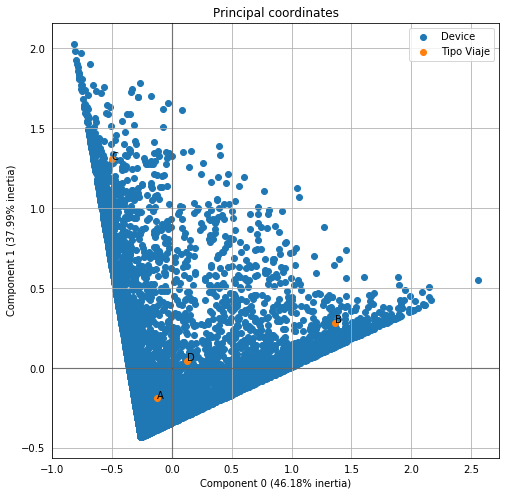

In [42]:
ax = ca.plot_coordinates(X=X,ax=None,figsize=(8, 8),x_component=0,y_component=1,show_row_labels=False,show_col_labels=True)

The graph above tells us that there is no particular agrupoations 

## Device vs Provincia Off

Relationship between the device and the end of the trips.

In [43]:
#ft_Dev_ProvOFF = Trips_f.where(F.col('OFF_N1')!='Pichincha').crosstab('DeviceId', 'OFF_N1')
ft_Dev_ProvOFF = Trips_f.crosstab('DeviceId', 'OFF_N1')
print('Frequency table for trip types for each Device')
print('Number of rows: ', "{:,}".format(ft_Dev_ProvOFF.count()))
print('Number of columns: ', len(ft_Dev_ProvOFF.columns))

Frequency table for trip types for each Device
Number of rows:  7,250
Number of columns:  25


In [44]:
ft_Dev_ProvOFF.show(5)

+---------------+-----+-------+------+------+----------+--------+------+----------+------+--------+----+--------+------+---------------+----+--------+-------+---------+-----------+------------------------------+---------+----------+----------------+------------------+
|DeviceId_OFF_N1|Azuay|Bolivar|Carchi|CaÃ±ar|Chimborazo|Cotopaxi|El Oro|Esmeraldas|Guayas|Imbabura|Loja|Los Rios|Manabi|Morona Santiago|Napo|Orellana|Pastaza|Pichincha|Santa Elena|Santo Domingo de los Tsachilas|Sucumbios|Tungurahua|Zamora Chinchipe|Zona No Delimitada|
+---------------+-----+-------+------+------+----------+--------+------+----------+------+--------+----+--------+------+---------------+----+--------+-------+---------+-----------+------------------------------+---------+----------+----------------+------------------+
|          37159|    0|      0|     0|     0|         0|       0|     0|         0|     0|       2|   0|       0|     0|              0|   0|       0|      0|       93|          0|             

In [45]:
X = ft_Dev_ProvOFF.toPandas()
X = X.set_index('DeviceId_OFF_N1', drop=True)
X.columns.rename('ProvOFF', inplace=True)
X.index.rename('Device', inplace=True)
#X.drop(['A', 'D'], axis=1, inplace=True)
#X.drop(['Zona No Delimitada', 
#        'Loja', 'Zamora Chinchipe',
        #'Carchi', 'Imbabura', 'CaÃ±ar', 'Azuay'
#       ], axis=0, inplace=True)
X = X.dropna()
X = X.loc[~(X==0).all(axis=1)]
X.head()

ProvOFF,Azuay,Bolivar,Carchi,CaÃ±ar,Chimborazo,Cotopaxi,El Oro,Esmeraldas,Guayas,Imbabura,...,Napo,Orellana,Pastaza,Pichincha,Santa Elena,Santo Domingo de los Tsachilas,Sucumbios,Tungurahua,Zamora Chinchipe,Zona No Delimitada
Device,,,,,,,,,,,,,,,,,,,,,
37159,0,0,0,0,0,0,0,0,0,2,...,0,0,0,93,0,0,0,0,0,0
31843,0,0,0,0,0,0,0,0,387,0,...,0,0,0,0,0,0,0,0,0,0
39241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,44,0,0,0,0,0,0
29862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39049,0,0,0,0,0,0,0,0,155,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
ca = prince.CA(n_components=3,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
ca = ca.fit(X)
ca.explained_inertia_

[0.060416517393823636, 0.05761504107917652, 0.055936646454692734]

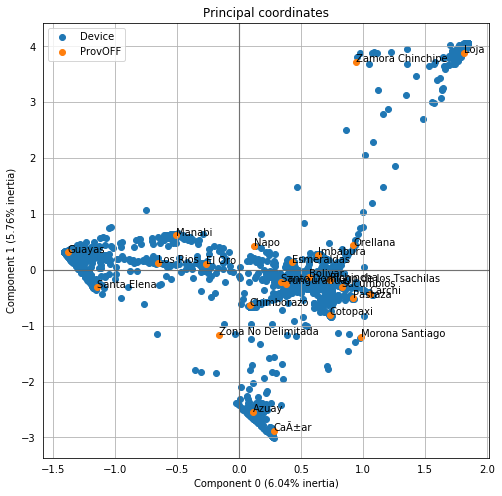

In [47]:
ax = ca.plot_coordinates(X=X,ax=None,figsize=(8, 8),x_component=0,y_component=1,show_row_labels=False,show_col_labels=True)

In the graph below, we can see four accumulations:

*	Group 1: Zamora Chinchipe and Loja
*	Group 2: Guayas, Santa Elena, Manabí, Los Ríos and El Oro. 
*	Group 3: Azuay and Cañar
*	Group 4: Pichincha, Santo Domingo de los Tsachilas, Pastaza, Cotopaxi, Esmeraldas, Imbabura, Napo, Orellana, Chimborazo, Carchi.

However, we will collapse the province of Azuay, Cañar, Zamora Chinchipe, Loja, Morona Santiago and “Zona No Deliminada” in one single category called: “**Otras**”.

We’ll call the group 2 of provinces: “**Guayas_y_alr**”. 

Finally, the group of provinces No. 4 will be called: “**Pich_y_alr**”.


In [48]:
cond = F.when(F.col('OFF_N1').isin(['Loja','Zamora Chinchipe', 'Azuay', 'CaÃ±ar', 
                                    'Zona No Delimitada', 'Morona Santiago',
                                    'Orellana']),'Otras').otherwise(F.when(F.col('OFF_N1').isin(['Guayas', 'Santa Elena', 
                                                                                                 'Manabi', 'Los Rios', 'El Oro']),'Guayas_y_alrededores').otherwise('Pich_y_alrededores'))
Trips_f = Trips_f.withColumn('Provincia_OFF', cond)

In [49]:
ft_Dev_ProvOFF = Trips_f.crosstab('DeviceId', 'Provincia_OFF')
print('Frequency table for trip types for each Device')
print('Number of rows: ', "{:,}".format(ft_Dev_ProvOFF.count()))
print('Number of columns: ', len(ft_Dev_ProvOFF.columns))

Frequency table for trip types for each Device
Number of rows:  7,250
Number of columns:  4


In [50]:
X = ft_Dev_ProvOFF.toPandas()
X = X.set_index('DeviceId_Provincia_OFF', drop=True)
X.columns.rename('ProvOFF', inplace=True)
X.index.rename('Device', inplace=True)
#X.drop(['A', 'D'], axis=1, inplace=True)
#X.drop(['Zona No Delimitada', 
#        'Loja', 'Zamora Chinchipe',
        #'Carchi', 'Imbabura', 'CaÃ±ar', 'Azuay'
#       ], axis=0, inplace=True)
X = X.dropna()
X = X.loc[~(X==0).all(axis=1)]
X.head()

ProvOFF,Guayas_y_alrededores,Otras,Pich_y_alrededores
Device,,,
37159,0,0,95
31843,387,0,0
39241,0,0,44
29862,156,0,0
39049,155,0,0


In [51]:
ca = prince.CA(n_components=2,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
ca = ca.fit(X)
ca.explained_inertia_

[0.5068242502236615, 0.4931757497763376]

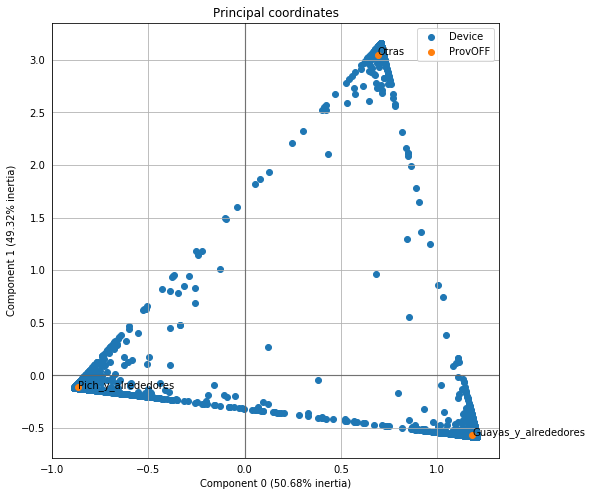

In [52]:
ax = ca.plot_coordinates(X=X,ax=None,figsize=(8, 8),x_component=0,y_component=1,show_row_labels=False,show_col_labels=True)

In [53]:
Trips_f.groupBy('Provincia_OFF').count().show()

+--------------------+-------+
|       Provincia_OFF|  count|
+--------------------+-------+
|  Pich_y_alrededores|1483888|
|               Otras| 232941|
|Guayas_y_alrededores| 951193|
+--------------------+-------+



In [54]:
cond = F.when(F.col('OFF_N1').isin(['Pichincha', 'Guayas']),F.col('OFF_N1')).otherwise('Otras')
Trips_f.withColumn('Prov_OFF', cond).groupBy('Prov_OFF').count().show()

+---------+-------+
| Prov_OFF|  count|
+---------+-------+
|    Otras| 748383|
|Pichincha|1142767|
|   Guayas| 776872|
+---------+-------+



## Device vs Province of ignition on

Let's see if the accumulations don't change.

In [55]:
ft_Dev_ProvON = Trips_f.crosstab('DeviceId', 'ON_N1')
print('Frequency table for trip types for each Device')
print('Number of rows: ', "{:,}".format(ft_Dev_ProvON.count()))
print('Number of columns: ', len(ft_Dev_ProvON.columns))

Frequency table for trip types for each Device
Number of rows:  7,250
Number of columns:  25


In [56]:
X = ft_Dev_ProvON.toPandas()
X = X.set_index('DeviceId_ON_N1', drop=True)
X.columns.rename('ProvON', inplace=True)
X.index.rename('Device', inplace=True)
#X.drop(['A', 'D'], axis=1, inplace=True)
#X.drop(['Zona No Delimitada', 
#        'Loja', 'Zamora Chinchipe',
        #'Carchi', 'Imbabura', 'CaÃ±ar', 'Azuay'
#       ], axis=0, inplace=True)
X = X.dropna()
X = X.loc[~(X==0).all(axis=1)]
X.head()

ProvON,Azuay,Bolivar,Carchi,CaÃ±ar,Chimborazo,Cotopaxi,El Oro,Esmeraldas,Guayas,Imbabura,...,Napo,Orellana,Pastaza,Pichincha,Santa Elena,Santo Domingo de los Tsachilas,Sucumbios,Tungurahua,Zamora Chinchipe,Zona No Delimitada
Device,,,,,,,,,,,,,,,,,,,,,
37159,0,0,0,0,0,0,0,0,0,3,...,0,0,0,92,0,0,0,0,0,0
31843,0,0,0,0,0,0,0,0,387,0,...,0,0,0,0,0,0,0,0,0,0
39241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,44,0,0,0,0,0,0
29862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39049,0,0,0,0,0,0,0,0,155,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
ca = prince.CA(n_components=2,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
ca = ca.fit(X)
ca.explained_inertia_

[0.06056836751334188, 0.05850600419513209]

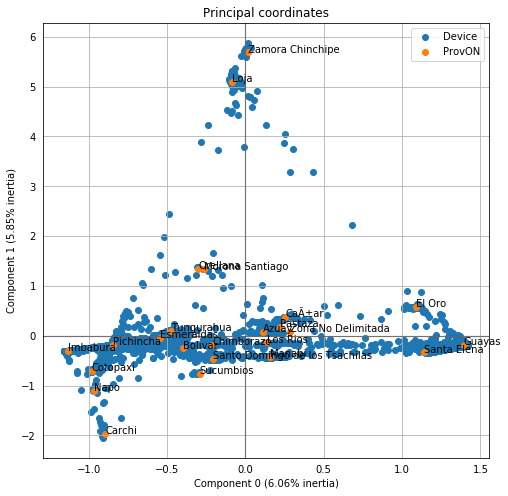

In [58]:
ax = ca.plot_coordinates(X=X,ax=None,figsize=(8, 8),x_component=0,y_component=1,show_row_labels=False,show_col_labels=True)

In [59]:
cond = F.when(F.col('ON_N1').isin(['Loja','Zamora Chinchipe', 'Zona No Delimitada']),'Otras').otherwise(F.col('ON_N1'))
Trips_f = Trips_f.withColumn('Provincia_ON', cond)

In [60]:
ft_Dev_ProvON = Trips_f.crosstab('DeviceId', 'Provincia_ON')
print('Frequency table for trip types for each Device')
print('Number of rows: ', "{:,}".format(ft_Dev_ProvON.count()))
print('Number of columns: ', len(ft_Dev_ProvON.columns))

Frequency table for trip types for each Device
Number of rows:  7,250
Number of columns:  23


In [61]:
X = ft_Dev_ProvON.toPandas()
X = X.set_index('DeviceId_Provincia_ON', drop=True)
X.columns.rename('ProvON', inplace=True)
X.index.rename('Device', inplace=True)
#X.drop(['A', 'D'], axis=1, inplace=True)
#X.drop(['Zona No Delimitada', 
#        'Loja', 'Zamora Chinchipe',
        #'Carchi', 'Imbabura', 'CaÃ±ar', 'Azuay'
#       ], axis=0, inplace=True)
X = X.dropna()
X = X.loc[~(X==0).all(axis=1)]
X.head()

ProvON,Azuay,Bolivar,Carchi,CaÃ±ar,Chimborazo,Cotopaxi,El Oro,Esmeraldas,Guayas,Imbabura,...,Morona Santiago,Napo,Orellana,Otras,Pastaza,Pichincha,Santa Elena,Santo Domingo de los Tsachilas,Sucumbios,Tungurahua
Device,,,,,,,,,,,,,,,,,,,,,
37159,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,92,0,0,0,0
31843,0,0,0,0,0,0,0,0,387,0,...,0,0,0,0,0,0,0,0,0,0
39241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,44,0,0,0,0
29862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39049,0,0,0,0,0,0,0,0,155,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
ca = prince.CA(n_components=2,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
ca = ca.fit(X)
ca.explained_inertia_

[0.06348541510826637, 0.06064971607023075]

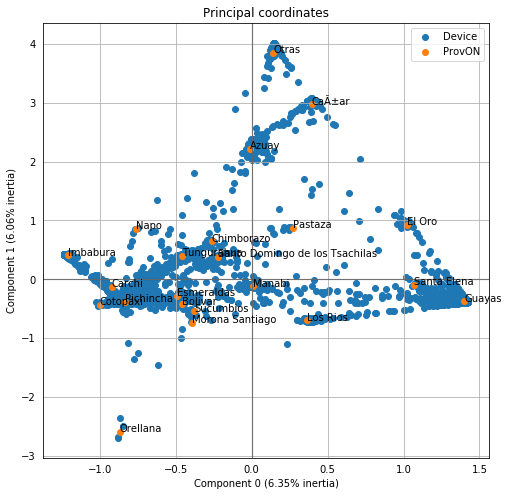

In [63]:
ax = ca.plot_coordinates(X=X,ax=None,figsize=(8, 8),x_component=0,y_component=1,show_row_labels=False,show_col_labels=True)

The accumulations of devices per province are approximately the same.